In [1]:
import inputs, simuls, analysis, fitPRd
from analysis import aesthetic_plot, iso_in_plots
from betaplus import beta_spectrum

import numpy as np
import matplotlib.pyplot as plt

results = analysis.GetResults(verbose=True)
x = fitPRd.x

# Generate branch spectra

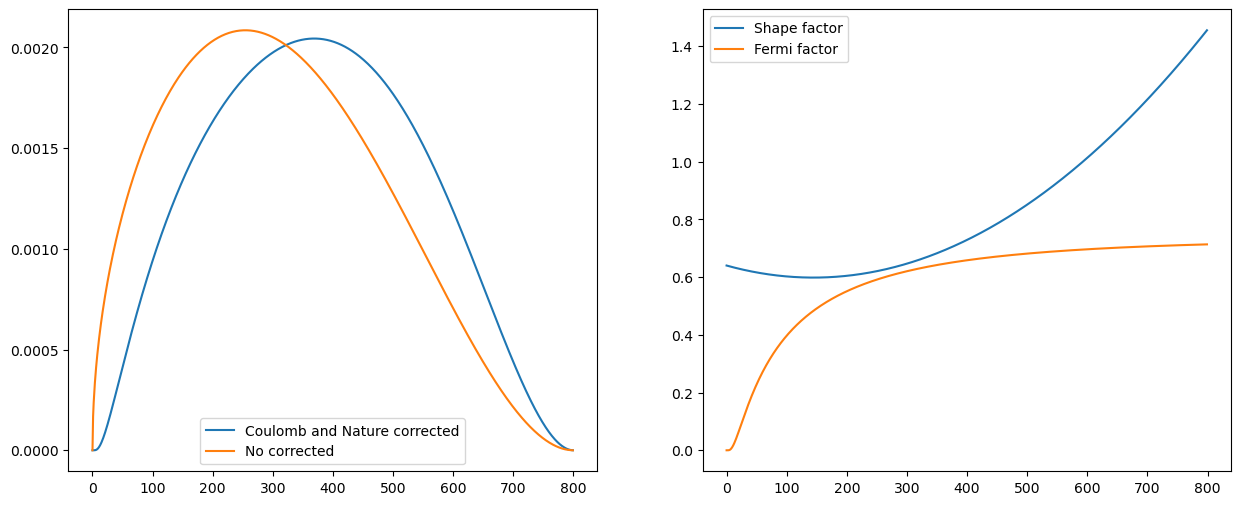

In [2]:
Z, A, Q = 29, 64, 800 
nature = 'first-forbidden unique' # 'allowed', 'first-forbidden', 'first-forbidden unique'
from betaplus import Fermi_factor, shape_factor

E, N, N0 = beta_spectrum(Q, Z, A, nature)
S = shape_factor(nature, Z, A, Q*1e-3, E*1e-3)
F = Fermi_factor(Z, E*1e-3)

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(E, N, label='Coulomb and Nature corrected')
plt.plot(E, N0, label='No corrected')
# plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.plot(E, S*np.ones_like(E), label='Shape factor')
plt.plot(E, F, label='Fermi factor')
plt.legend()
plt.show()

### Define Ga68, Rb82 and I124 branches 

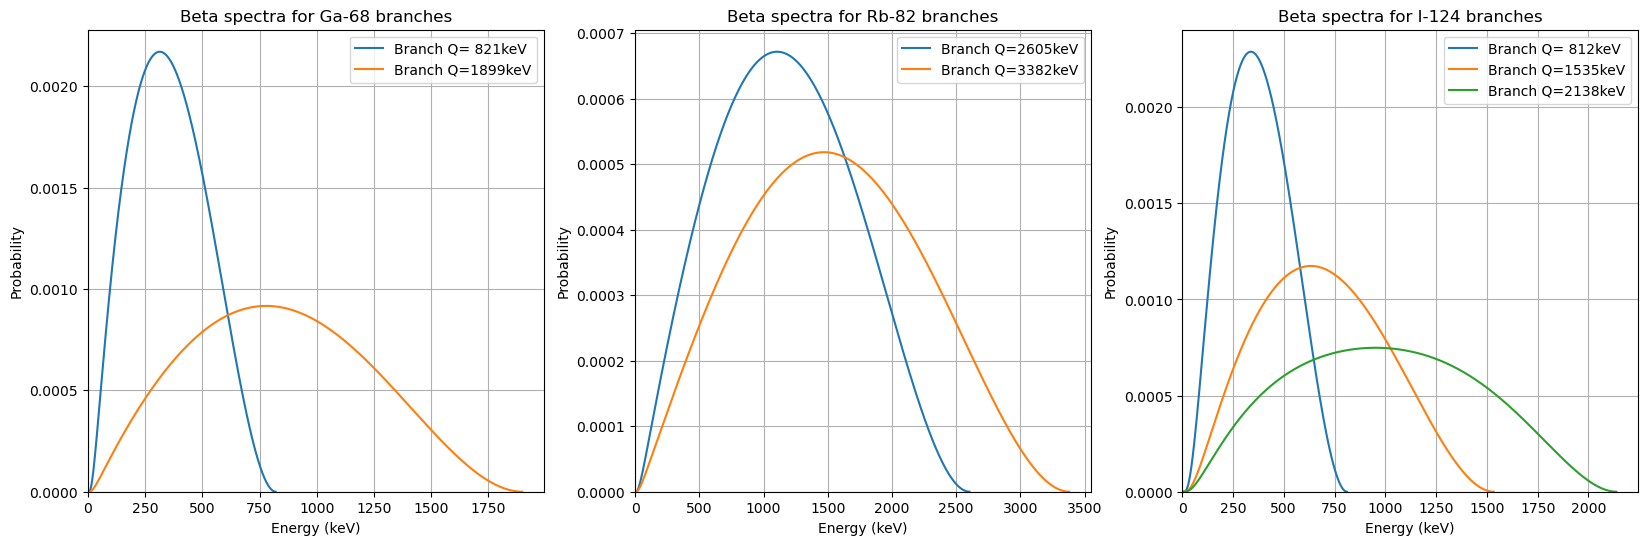

In [3]:
Ga68branches = [   
    # Nature     Q(keV)  E(keV)  Weight 
     ('allowed',  821,    352,    1.4e-2),
     ('allowed', 1899,    836,   98.6e-2),
]

Rb82branches = [
    # Nature     Q(keV)  E(keV)  Weight
     ('allowed', 2605,   1169,   13.6e-2 + 0.7e-2),   # Add remianing branches 
     ('allowed', 3382,   1536,   86.4e-2),
]

I124branches = [
    # Nature                    Q(keV)  E(keV)  Weight
     ('first-forbidden',         812,    367,    1.3e-2 + 0.1e-2),   # Add remaining branches
     ('first-forbidden',        1535,    687,   51.5e-2),
     ('first-forbidden unique', 2138,    974,   47.1e-2),
]

MB = {
    'Ga68': {
        'Z': 31,
        'A': 68,
        'branches': Ga68branches,
    },
    'Rb82': {
        'Z': 37,
        'A': 82,
        'branches': Rb82branches,
    },
    'I124': {
        'Z': 53,
        'A': 124,
        'branches': I124branches,
    },
}

plt.figure(figsize=(5*(len(MB)+1), 6))
k = 0
for isotope, data in MB.items():
    plt.subplot(1, len(MB), (k:=k+1))
    Z = data['Z']
    A = data['A']
    branches = data['branches']
    for i, (nat,Q,Emean,w) in enumerate(branches):
        E, NF, N = beta_spectrum(Q, Z, A, nat)
        plt.plot(E, NF, label=f'Branch {Q=:>4d}keV')

    plt.xlabel('Energy (keV)')
    plt.ylabel('Probability')
    plt.title(f'Beta spectra for {analysis.iso_in_plots(isotope)} branches')
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.legend()
    plt.grid()
plt.show()

# Run simulations

## PenEasy SPC

In [14]:
pid = 'SPC'
ver = '24'
# Initialize PenEasy Input Editor
peneasy_inps = inputs.PenEasy(verbose=True)

# Initialize Simulators (identified by pid)
peneasy_sims = simuls.PenEasy(verbose=True)
peneasy_sims.activate_pid(pid, ver)

# Set up simulation inputs
SIZE = [1]*3   
STEP = [8.0]*3  #cm
nhist = "1e6"

MATS = [
    #material   mat_name   mat_id  density (g/cm3)
    {'lung' : ['lungICRP', 1,     0.30]},
    {'water': ['water',    1,     1.00]},
    {'bone' : ['boneB100', 1,     1.45]},
]

peneasy_inps.edit_seed(pid)
peneasy_inps.edit_source_nhist(pid, nhist)
peneasy_inps.edit_voxSize(pid, SIZE, STEP)

penEasy 2024 SPC activated
"penEasy/pen*.in" random seeds modified to 36916 and 7859
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" number of histories modified to 1e6
"penEasy/phantomN.vox" updated to point source of activity 1e6
"penEasy/pen??_spc.in" and "penEasy/pen??_nuc.in" coordinates of box center modified to (4, 4, 4)
"penEasy/phantomN.vox" voxel size modified to (8.0, 8.0, 8.0)


In [17]:
peneasy_inps.verbose = False
for iso, data in MB.items():
    print(f"****SIMULATING {iso}****")
    Z = data['Z']
    A = data['A']
    branches = data['branches']
    for i, (nat,Q,Emean,w) in enumerate(branches):
        print(f"----Simulating branch {i+1} (Q={Q:d} keV, Emean={Emean:d} keV, weight={w*100:.1f}%)")
        E, NF, N = beta_spectrum(Q, Z, A, nat)
        spec = np.column_stack((E*1e3, NF))
        spec = np.vstack((spec, np.array([spec[-1,0], -1])))
        np.savetxt('penEasy/pnnc_spec.dat', spec, header='Energy(eV) probability', fmt="%8.7e\t%10.9f")
        for MAT in MATS:
            material = list(MAT.keys())[0]
            print(f"--Simulating {material}")
            peneasy_inps.edit_mat(pid, MAT, SIZE, STEP)
        
            res_folder = f"RESULTS/MB/{material.capitalize()}/PenEasy20{ver}_xyz"
            peneasy_sims.simulate(pid, get_times=True, time_samples=1, output_dir=res_folder, final_file=f"{iso}-b{i+1}.dat.original")
    print("\n")

****SIMULATING I124****
----Simulating branch 0 (Q=812 keV, Emean=367 keV, weight=1.4%)
--Simulating lung
penEasy 2024 SPC real time: 121.290 +- 0.000 s
--Simulating water
penEasy 2024 SPC real time: 120.532 +- 0.000 s
--Simulating bone
penEasy 2024 SPC real time: 134.254 +- 0.000 s
----Simulating branch 1 (Q=1535 keV, Emean=687 keV, weight=51.5%)
--Simulating lung
penEasy 2024 SPC real time: 132.806 +- 0.000 s
--Simulating water
penEasy 2024 SPC real time: 132.407 +- 0.000 s
--Simulating bone
penEasy 2024 SPC real time: 147.392 +- 0.000 s
----Simulating branch 2 (Q=2138 keV, Emean=974 keV, weight=47.1%)
--Simulating lung
penEasy 2024 SPC real time: 140.604 +- 0.000 s
--Simulating water
penEasy 2024 SPC real time: 140.780 +- 0.000 s
--Simulating bone
penEasy 2024 SPC real time: 155.383 +- 0.000 s




In [17]:
isobranch = []
for iso in MB.keys():
    for i in range(len(MB[iso]['branches'])):
        isobranch += [f"{iso}-b{i+1}"]

for MAT in MATS:
    material = list(MAT.keys())[0]
    res_folder = f"RESULTS/MB/{material.capitalize()}/PenEasy20{ver}_xyz"
    times_file = res_folder + "/" + pid + "_times.txt"
    times = np.loadtxt(times_file).astype("str")
    times[:,1], times[:,0] = times[:,0], isobranch
    np.savetxt(times_file, times, fmt='%s')
    print(f"Saved times for {material} in {times_file}")

Saved times for lung in RESULTS/MB/Lung/PenEasy2024_xyz/SPC_times.txt
Saved times for water in RESULTS/MB/Water/PenEasy2024_xyz/SPC_times.txt
Saved times for bone in RESULTS/MB/Bone/PenEasy2024_xyz/SPC_times.txt


## Filter ultra-long range positrons

In [ ]:
program_folder = "PenEasy2024_xyz"
trim = int(1e6)

def Rmax(_Q, _rho):
    """
    Calculate the maximum range of beta particles in a given material.
    Parameters:
    _Q (float): The Q value of the beta decay (in MeV).
    _rho (float): The density of the material (in mg/cm^3).
    Returns:
    Rmax (float): The maximum range of beta particles in the material (in cm).
    """
    if _Q <= 2.5:
        num = 412 * _Q ** (1.265 - 0.0954 * np.log(_Q))
    elif _Q <= 20:
        num = 530 * _Q - 106
    else:
        raise ValueError("Q value is too high for this model.")
    Rmax = num / _rho
    return Rmax

for MAT in MATS:
    material = list(MAT.keys())[0]
    dens = MAT[material][2]
    folder = f"RESULTS/MB/{material.capitalize()}/{program_folder}"
    print(f"****FILTERING {material}****")
    for iso in MB.keys():
        # if material == 'water' or iso == 'Ga68': continue
        print(f"----Filtering {iso}")
        branches = MB[iso]['branches']
        for i, (nat,Q,Emean,w) in enumerate(branches):
            isob = f"{iso}-b{i+1}"
            print(f"--Branch {i+1}")
            threshold = Rmax(Q*1e-3, dens*1e3)  # Convert Q to MeV and density to mg/cm^3
            threshold *= 10 # Convert to mm
            print(f"Threshold: {threshold:.2f} mm")
            analysis.filter_rmax(f"{folder}/{isob}.dat.original", f"{folder}/{isob}.dat", threshold=threshold, trim=trim, fmt='%.6f')

****FILTERING lung****
----Filtering Rb82
--Branch 1
Threshold: 42.49 mm
Filtered 'RESULTS/SPC/Lung/PenEasy2024_xyz/Rb82.dat.original' to 'RESULTS/SPC/Lung/PenEasy2024_xyz/Rb82.dat': 6394 points removed
--Branch 2
Threshold: 56.22 mm
Filtered 'RESULTS/SPC/Lung/PenEasy2024_xyz/Rb82.dat.original' to 'RESULTS/SPC/Lung/PenEasy2024_xyz/Rb82.dat': 3 points removed
----Filtering I124
--Branch 1
Threshold: 10.51 mm
Filtered 'RESULTS/SPC/Lung/PenEasy2024_xyz/I124.dat.original' to 'RESULTS/SPC/Lung/PenEasy2024_xyz/I124.dat': 321835 points removed
--Branch 2
Threshold: 23.21 mm
Filtered 'RESULTS/SPC/Lung/PenEasy2024_xyz/I124.dat.original' to 'RESULTS/SPC/Lung/PenEasy2024_xyz/I124.dat': 18174 points removed
--Branch 3
Threshold: 33.99 mm
Filtered 'RESULTS/SPC/Lung/PenEasy2024_xyz/I124.dat.original' to 'RESULTS/SPC/Lung/PenEasy2024_xyz/I124.dat': 16 points removed
****FILTERING water****
****FILTERING bone****
----Filtering Rb82
--Branch 1
Threshold: 8.79 mm
Filtered 'RESULTS/SPC/Bone/PenEasy2024_x

# G3D Fitting

## Rough fitting

**********-PHITS_xyz-**********
Water - Ga68        	n1=1.0000	rmse=0.0	chi2=244.5 (1.57%)	final_params={a1: 0.332, b1: 0.0, c1: 0.169, n1: 1.416, a2: 17.6, b2: 47.755, c2: 95.438, n2: 1.866}
Water - Rb82        	n1=1.0000	rmse=0.0	chi2=0.1 (0.03%)	final_params={a1: 0.14, b1: 0.049, c1: 0.096, n1: 1.356, a2: 0.214, b2: 0.0, c2: 0.102, n2: 1.958}
Water - I124        	n1=1.0000	rmse=0.0	chi2=393.7 (1.99%)	final_params={a1: 0.258, b1: 0.097, c1: 0.012, n1: 2.0, a2: 0.564, b2: 0.0, c2: 0.0, n2: 1.547, a3: 10.313, b3: 5.315, c3: 59.384, n3: 1.997}
Lung - Ga68         	n1=1.0000	rmse=0.0	chi2=550.3 (2.35%)	final_params={a1: 0.099, b1: 0.0, c1: 0.051, n1: 1.418, a2: 17.666, b2: 53.013, c2: 112.187, n2: 1.978}
Bone - Ga68         	n1=1.0000	rmse=0.0	chi2=172.9 (1.32%)	final_params={a1: 0.48, b1: 0.0, c1: 0.233, n1: 1.415, a2: 35.195, b2: 6.66, c2: 188.718, n2: 1.716}


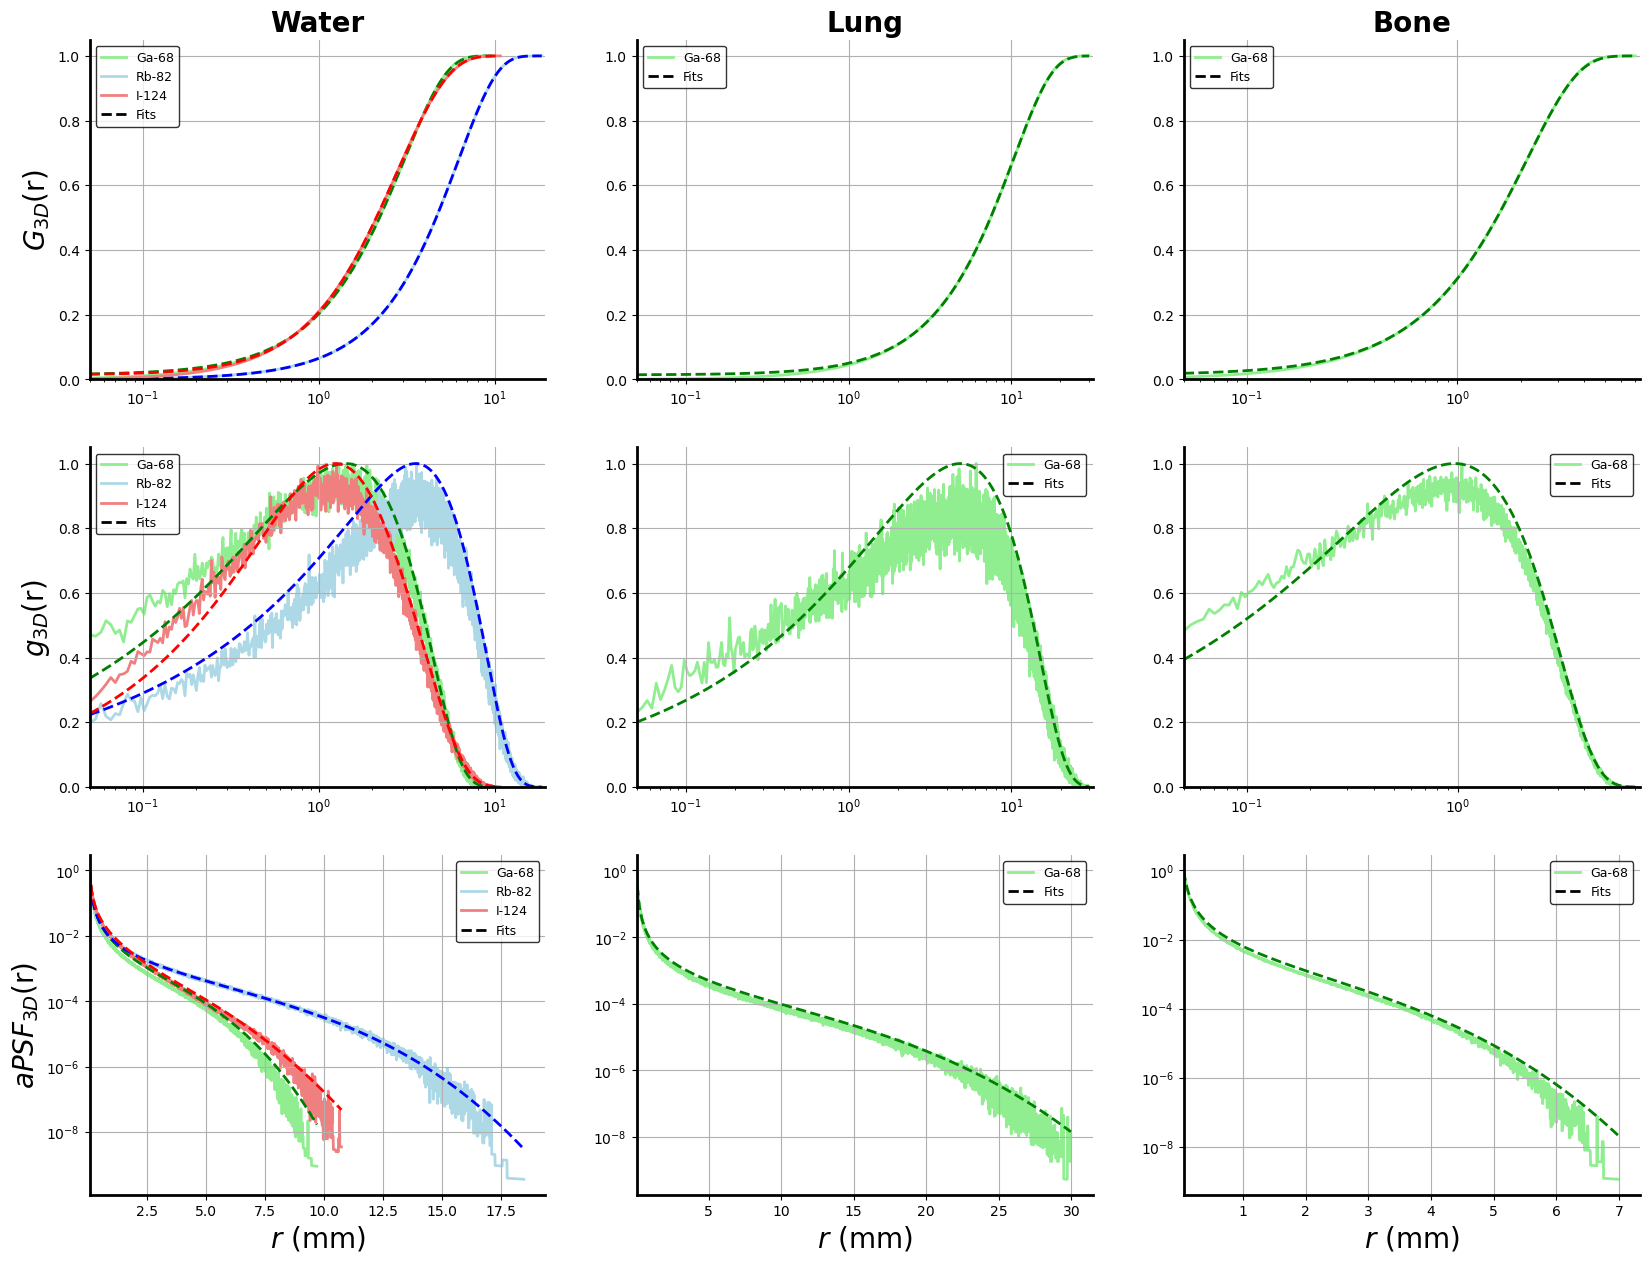

**********-PenEasy2024_xyz-**********
Water - Ga68        	n1=1.0000	rmse=0.0	chi2=303.7 (1.75%)	final_params={a1: 0.314, b1: 0.0, c1: 0.166, n1: 1.427, a2: 17.588, b2: 48.312, c2: 97.402, n2: 1.165}
Water - Rb82        	n1=1.0000	rmse=0.0	chi2=0.2 (0.04%)	final_params={a1: 0.131, b1: 0.046, c1: 0.096, n1: 1.353, a2: 0.209, b2: 0.0, c2: 0.115, n2: 1.967}
Water - I124        	n1=1.0000	rmse=0.0	chi2=456.8 (2.14%)	final_params={a1: 0.507, b1: 0.0, c1: 0.002, n1: 1.562, a2: 0.221, b2: 0.139, c2: 0.006, n2: 2.0, a3: 13.13, b3: 31.132, c3: 57.454, n3: 1.865}
Lung - Ga68         	n1=1.0000	rmse=0.0	chi2=658.4 (2.57%)	final_params={a1: 0.094, b1: 0.0, c1: 0.05, n1: 1.429, a2: 16.943, b2: 53.505, c2: 115.91, n2: 1.7}
Bone - Ga68         	n1=1.0000	rmse=0.0	chi2=213.3 (1.46%)	final_params={a1: 0.448, b1: 0.0, c1: 0.227, n1: 1.421, a2: 39.22, b2: 3.715, c2: 197.849, n2: 1.571}


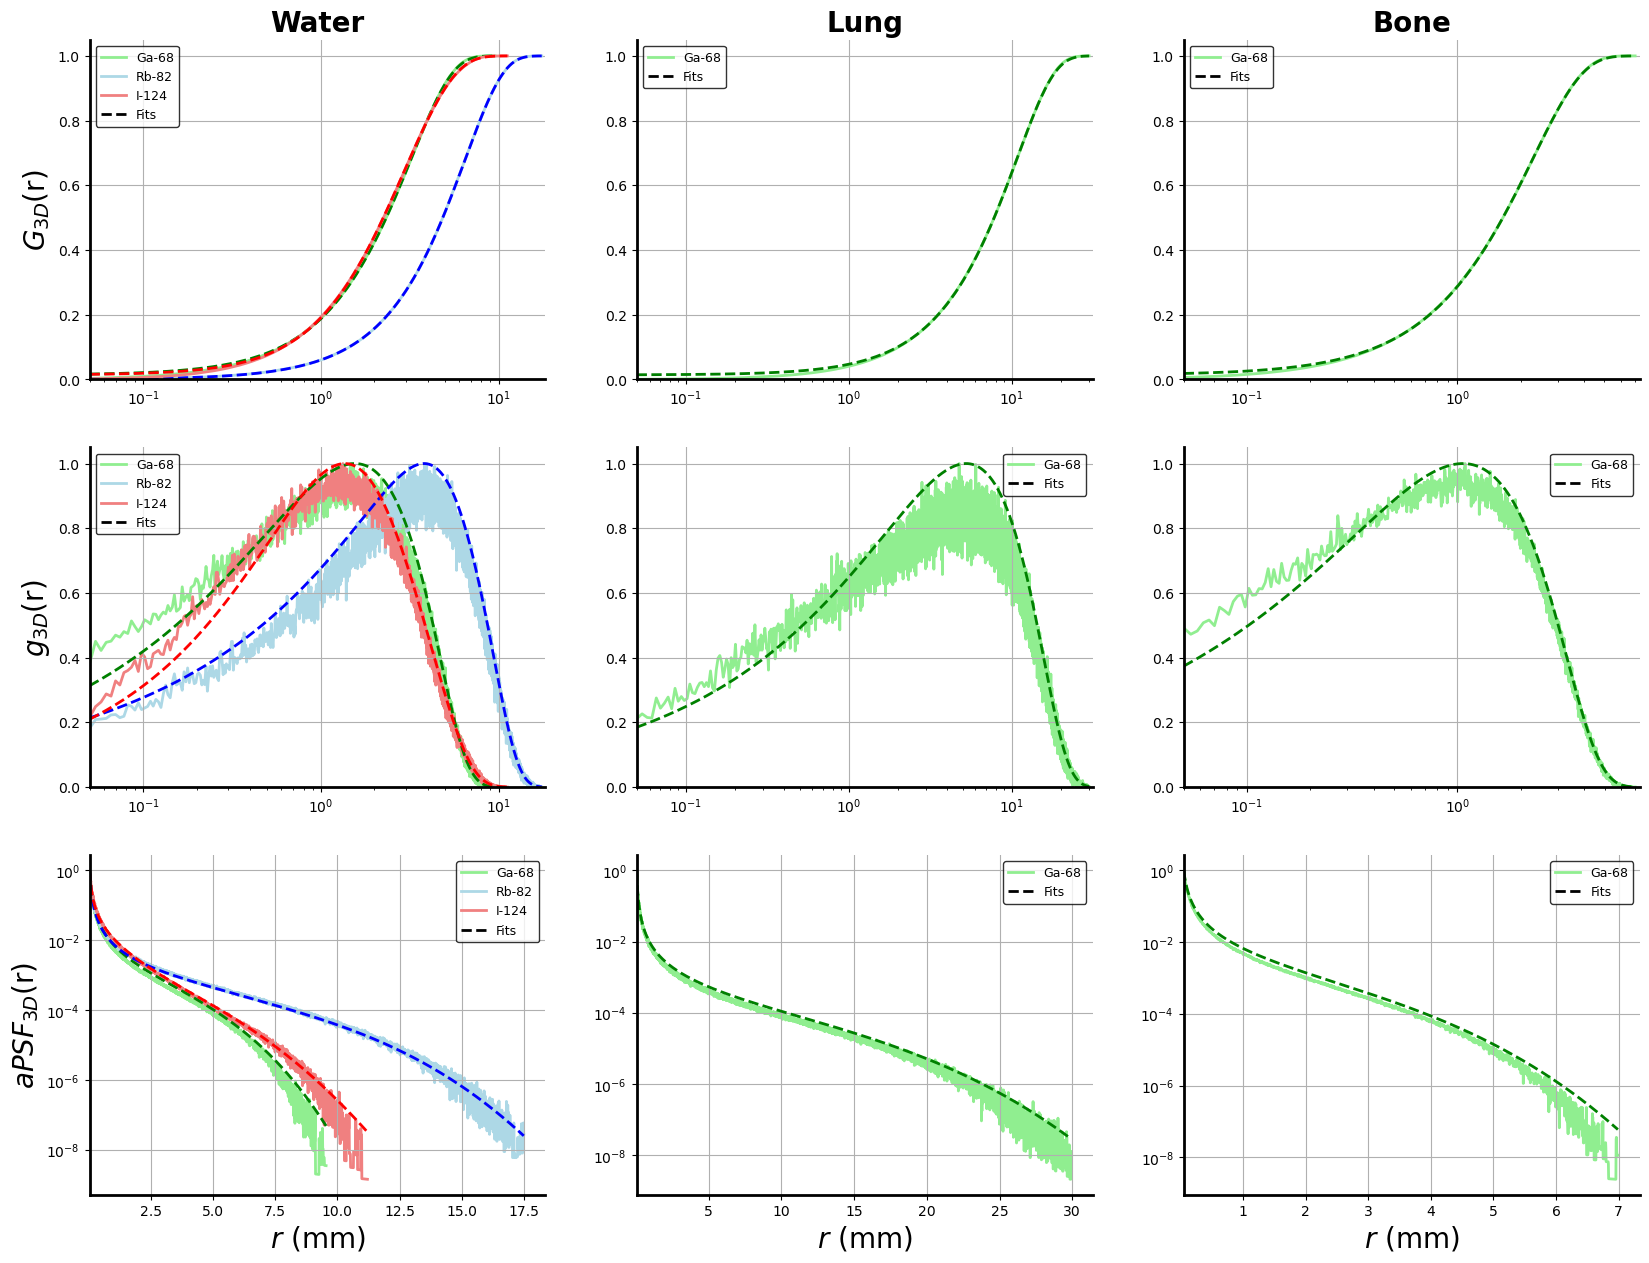

**********-GATE93_xyz-**********
Water - Ga68        	n1=1.0000	rmse=0.0	chi2=203.4 (1.43%)	final_params={a1: 0.335, b1: 0.12, c1: 0.186, n1: 1.374, a2: 40.987, b2: 3.377, c2: 207.054, n2: 1.996}
Water - Rb82        	n1=1.0000	rmse=0.0	chi2=0.9 (0.09%)	final_params={a1: 0.124, b1: 0.112, c1: 0.078, n1: 1.395, a2: 0.141, b2: 0.257, c2: 0.003, n2: 1.001}
Water - I124        	n1=1.0000	rmse=0.0	chi2=410.5 (2.03%)	final_params={a1: 0.301, b1: 0.002, c1: 0.146, n1: 1.531, a2: 0.467, b2: 0.0, c2: 0.206, n2: 1.449, a3: 22.123, b3: 7.133, c3: 128.276, n3: 1.813}
Lung - Ga68         	n1=1.0000	rmse=0.0	chi2=545.6 (2.34%)	final_params={a1: 0.113, b1: 0.0, c1: 0.053, n1: 1.449, a2: 17.965, b2: 52.367, c2: 109.316, n2: 1.174}
Bone - Ga68         	n1=1.0000	rmse=0.0	chi2=162.3 (1.28%)	final_params={a1: 0.498, b1: 0.0, c1: 0.26, n1: 1.343, a2: 22.434, b2: 16.529, c2: 163.868, n2: 1.804}


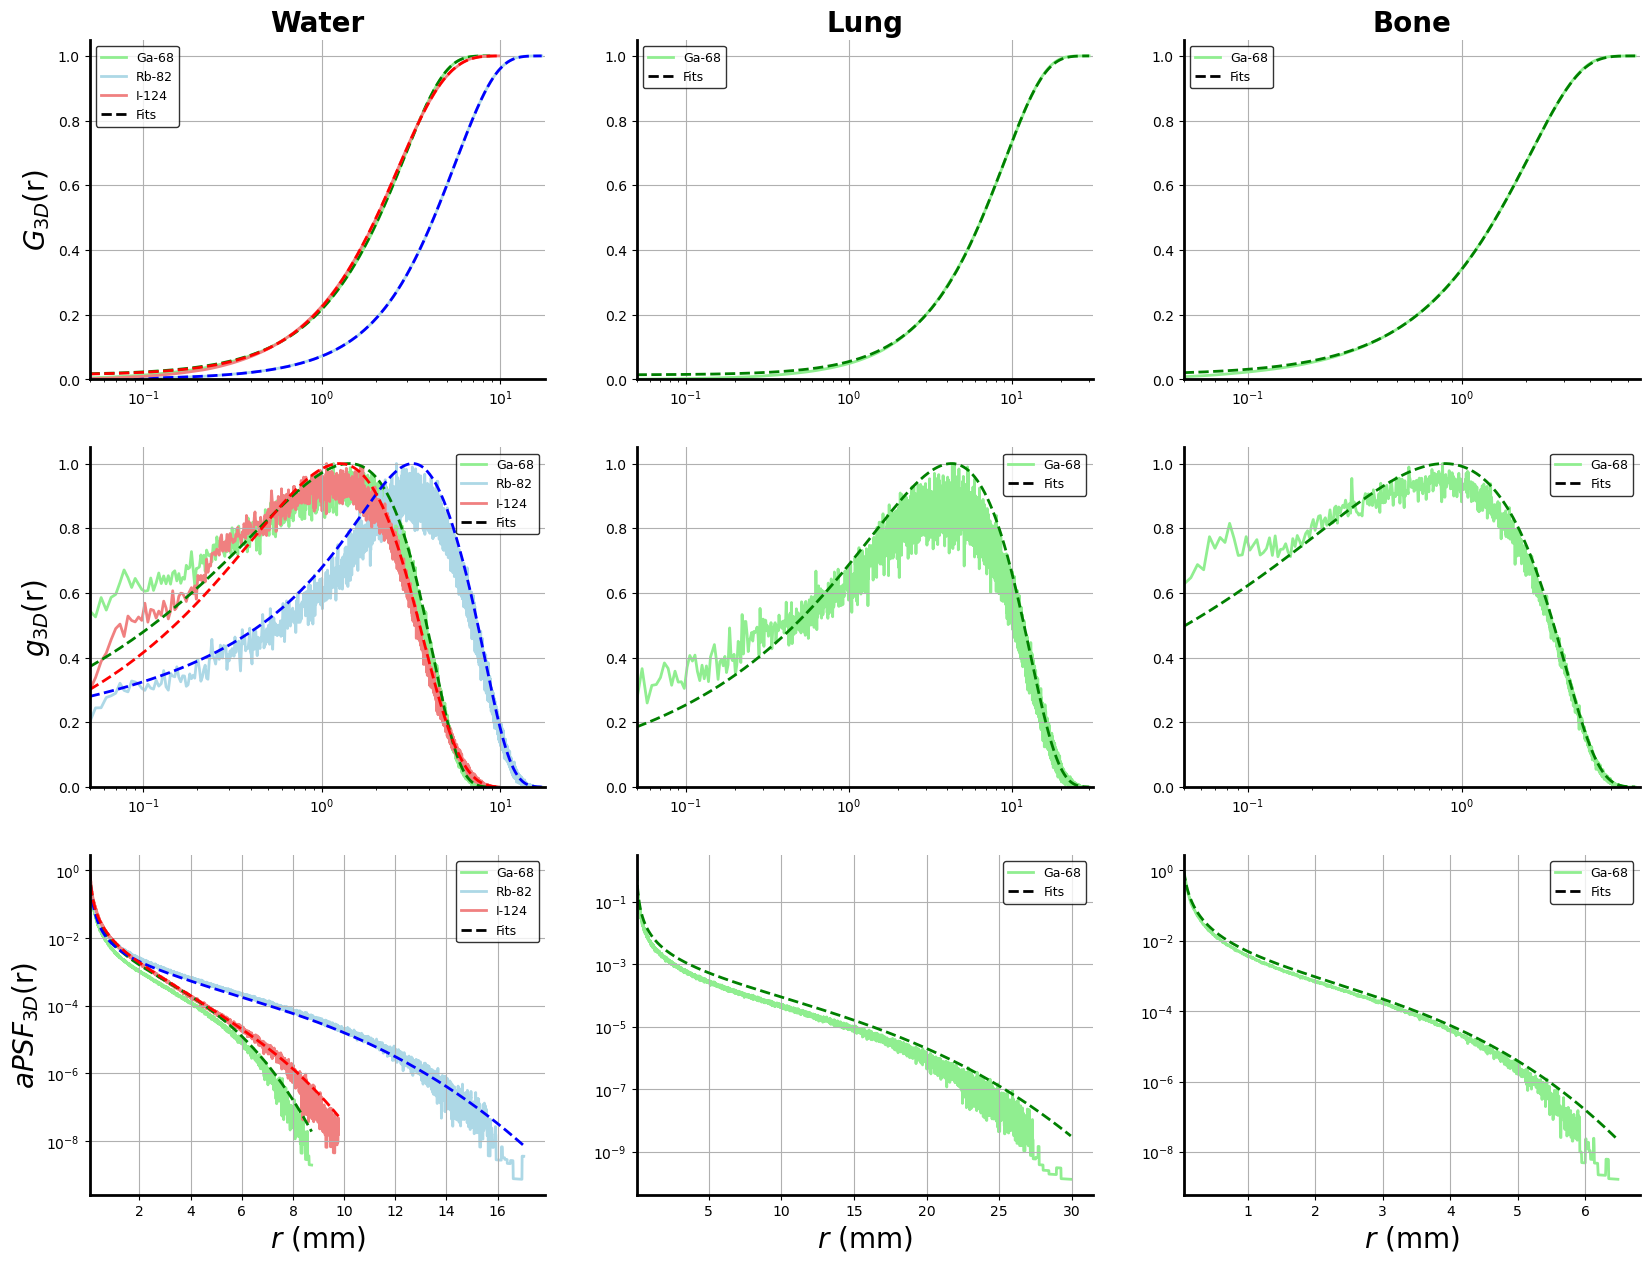

In [ ]:
colors1 = ['g', 'b', 'r', 'c', 'm']
colors2 = ['lightgreen', 'lightblue', 'lightcoral', 'paleturquoise', 'violet']
colors = list(zip(colors1, colors2))
cfolders = {
    "PHITS_xyz":"PHITS",
    # "PenEasy2020_xyz":"SPC",
    "PenEasy2024_xyz":"SPC",
    # "PeneloPET2024_xyz":"2024",
    # "GATE92_xyz":"9",
    "GATE93_xyz":"9",
    # "GATE7_xyz":"7",
}
clabels = {
    "PHITS_xyz":"PHITS 3.3",
    "PenEasy2020_xyz":"PenEasy 2020",
    "PenEasy2024_xyz":"PenEasy 2024",
    "PeneloPET2024_xyz":"PeneloPET 2024",
    "GATE92_xyz":"GATE 9.2",
    "GATE93_xyz":"GATE 9.3",
    "GATE7_xyz":"GATE 7.0",
}
ffolder = "SPC" # SPC for Coulomb effect, noCoulomb for no Coulomb effect
materials = ["Water", "Lung", "Bone"]       #, "Lung", "Bone"]
isotopes = ["Ga68", "Rb82", "I124"]
iso_colors = dict(zip(isotopes, colors))
bs = 4e-4      #cm
rm = 5e-2      #mm 5e-2

# Defining fitting function
preffix="n_is_param"
save_fits = False
#-->Generic multi-branch
        
Fit_Ga68 = fitPRd.MBfit_function(98.6, 1.4)
Fit_Rb82 = fitPRd.MBfit_function(85.7, 13.6 + 0.7)
Fit_I124 = fitPRd.MBfit_function(51.5, 47.1, 1.3 + 0.1)

for cfolder, pid in cfolders.items():
    print(f"**********-{cfolder}-**********")
    plt.figure(figsize=(20,15))
    for k,mat in enumerate(materials,1):
        save_file = f"RESULTS/{ffolder}/{mat}/{cfolder}/{pid}-mb_fit-{preffix}.txt"
        save_txt = ""
        for iso in isotopes:
            if mat in ["Lung", "Bone"] and iso not in ["C11", "F18", "Ga68"]: continue
            if cfolder == "GATE7_xyz" and iso not in ["C11", "O15", "F18"]: continue
            if cfolder == "PeneloPET2020_xyz" and (iso in ["Cu64"] or mat in ["Lung", "Bone"]): continue
            
            # Select fitting function method
            match iso:
                case "Ga68": fit_func, argsP, argsC = Fit_Ga68
                case "Rb82": fit_func, argsP, argsC = Fit_Rb82
                case "I124": fit_func, argsP, argsC = Fit_I124
                case _: raise ValueError(f"Isotope {iso} not defined")

            # Append isotope fitting info
            save_txt += "\n"*2 + f"# Fitting function: {fit_func.name}\n"
            save_txt += "# Constants: " + (f"{fit_func.consts}" if fit_func.consts else "None") + "\n"
            save_txt += f"# {'Isotope':<8} {'residue':<10} {'rmse':<10} {'chi2':<10} " + ' '.join([f"{str(p):<6}" for p in argsP]) +  ' '.join([f"{str(c):<6}" for c in argsC]) + "\n"

            # Load sample
            input_file = f"RESULTS/{ffolder}/{mat}/{cfolder}/{iso}.dat" # in cm
            sample_r, sample_G3D = fitPRd.load_nonhisto_G3D(input_file)
            sample_rp, sample_g3D = fitPRd.load_nonhisto_g3D(input_file, tol=bs)
            sample_rp, sample_aPSF3D = fitPRd.load_nonhisto_aPSF3D(input_file, tol=bs)
            sample_r *= 10
            sample_rp *= 10
            trimed_rp = sample_rp[sample_rp > rm]

            # Substitute constants
            ce = [1]#fitPRd.coulomb_effect(iso)    # Coulomb effect
            cvals = list(ce)
            fit_func.consts = {C:V for C,V in zip(argsC, cvals)}

            # Iterate initial parameters for best fitting 
            min_res = (1e10, fit_func.init_params) 
            for i0 in np.linspace(0, 1.6, 3):
                fit_func.init_params = [i0,] * len(argsP)
                res, chi2 = fit_func.fit(sample_r, sample_G3D, rmin=rm)
                if res < min_res[0]:
                    min_res = (res, fit_func.fitted_params)
            fit_func.init_params = min_res[1]
            res, chi2 = fit_func.fit(sample_r, sample_G3D, rmin=rm)
            stderr = fit_func.stderr
            rmse = fit_func.rmse

            # Get final fitting expressions
            final_params = fit_func.get_params(redon=3, with_err=False)
            print(f"{' - '.join([mat, iso]):<20}\tn1={ce[0]:<5.4f}\t{rmse=:.1f}\t{chi2=:.1f} ({stderr*100:.2f}%)\t{final_params=}")
            # fit_func.show_info(redon=4)
            fit_G3D = fit_func.get_G3D()
            fit_g3D = fit_func.get_g3D()
            fit_aPSF3D = fit_func.get_aPSF3D()

            # Plot
            fc, dc = iso_colors[iso]

            plt.subplot(3,3,k)
            plt.plot(sample_r, sample_G3D, '-', label=f'{iso_in_plots(iso)}', color=dc)
            plt.plot(sample_r, fit_G3D(sample_r), '--', label='', color=fc)

            plt.subplot(3,3,k+len(materials))
            plt.plot(trimed_rp, sample_g3D[sample_rp > rm]/sample_g3D[sample_rp > rm].max(), '-', label=f'{iso_in_plots(iso)}', color=dc, zorder=1)
            plt.plot(trimed_rp, (gg:=fit_g3D(trimed_rp))/gg.max(), '--', label='', color=fc, zorder=2)

            plt.subplot(3,3,k+2*len(materials))
            plt.plot(trimed_rp, sample_aPSF3D[sample_rp > rm]/sample_aPSF3D[sample_rp > rm].max(), '-', label=f'{iso_in_plots(iso)}', color=dc, zorder=1)
            plt.plot(trimed_rp, (gg:=fit_aPSF3D(trimed_rp))/gg.max(), '--', label='', color=fc, zorder=2)

            # Save fit parameters
            save_txt += f"{iso:<9}  {res:<10.3f} {rmse:<10.2e} {chi2:<10.3f} " + \
                        ' '.join([f"{p:<6.3f}" for p in final_params.values()]) + \
                        ' '.join([f"{c:<6.3f}" for c in fit_func.consts.values()]) + "\n"

        plt.subplot(3,3,k)
        plt.plot([], [], 'k--', label='Fits')
        plt.title(f'{mat}')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$G_{3D}$(r)')
        plt.xlim(rm, None)
        plt.xscale('log')
        aesthetic_plot()
        
        plt.subplot(3,3,k+len(materials))
        plt.plot([], [], 'k--', label='Fits')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$g_{3D}$(r)')
        plt.xlim(rm, None)
        # plt.ylim(7e-1, 1)
        plt.xscale('log')
        aesthetic_plot()

        plt.subplot(3,3,k+2*len(materials))
        plt.plot([], [], 'k--', label='Fits')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$aPSF_{3D}$(r)')
        plt.xlabel(r'$r$ (mm)')
        plt.yscale('log')
        plt.xlim(rm, None)
        aesthetic_plot()

        # Save fit parameters for given material and pid
        if save_fits:
            with open(save_file, 'w') as f:
                f.write(save_txt)
    plt.show()

## Splitted fitting

**********-PenEasy2024_xyz-**********
Water - Ga68-b1     	n1=1.0000	rmse=5.0e-04	chi2=5.1e+00 (0.23%)	final_params={a1: 1.048, b1: 0.0, c1: 0.475, n1: 1.271}
Water - Ga68-b2     	n1=1.0000	rmse=3.9e-04	chi2=8.1e-01 (0.09%)	final_params={a1: 0.289, b1: 0.137, c1: 0.159, n1: 1.322}
Water - Rb82-b1     	n1=1.0000	rmse=4.2e-04	chi2=7.2e-01 (0.09%)	final_params={a1: 0.191, b1: 0.084, c1: 0.114, n1: 1.408}
Water - Rb82-b2     	n1=1.0000	rmse=6.2e-04	chi2=3.7e+00 (0.19%)	final_params={a1: 0.135, b1: 0.063, c1: 0.087, n1: 1.451}
Water - I124-b1     	n1=1.0000	rmse=1.7e-03	chi2=4.4e+01 (0.66%)	final_params={a1: 1.007, b1: 0.0, c1: 0.421, n1: 1.443}
Water - I124-b2     	n1=1.0000	rmse=6.4e-04	chi2=6.9e+00 (0.26%)	final_params={a1: 0.412, b1: 0.0, c1: 0.21, n1: 1.458}
Water - I124-b3     	n1=1.0000	rmse=9.2e-04	chi2=1.3e+01 (0.36%)	final_params={a1: 0.241, b1: 0.0, c1: 0.15, n1: 1.369}
Lung - Ga68-b1      	n1=1.0000	rmse=4.7e-04	chi2=9.6e+00 (0.31%)	final_params={a1: 0.312, b1: 0.0, c1: 0.142, n

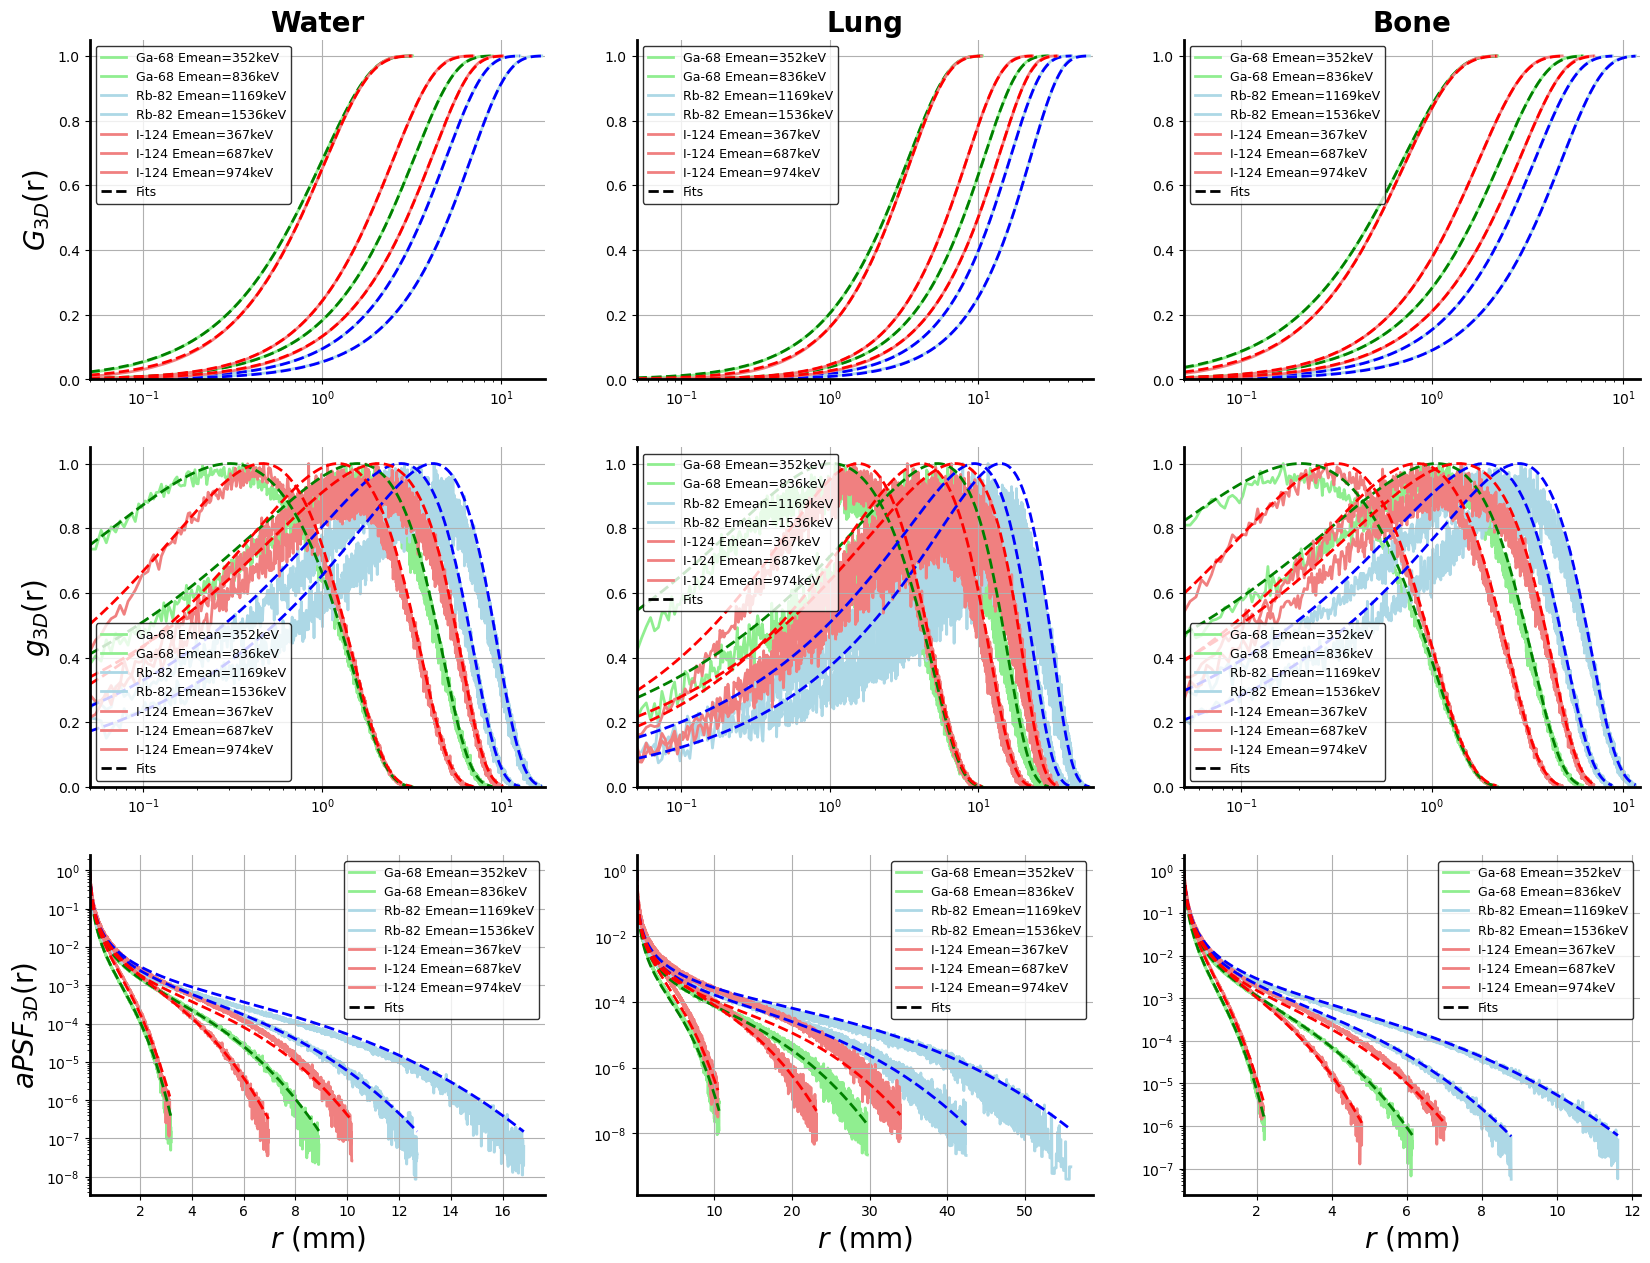

In [7]:
colors1 = ['g', 'b', 'r', 'c', 'm']
colors2 = ['lightgreen', 'lightblue', 'lightcoral', 'paleturquoise', 'violet']
colors = list(zip(colors1, colors2))
cfolders = {
    # "PHITS_xyz":"PHITS",
    # "PenEasy2020_xyz":"SPC",
    "PenEasy2024_xyz":"SPC",
    # "PeneloPET2024_xyz":"2024",
    # "GATE92_xyz":"9",
    # "GATE93_xyz":"9",
    # "GATE7_xyz":"7",
}
clabels = {
    "PHITS_xyz":"PHITS 3.3",
    "PenEasy2020_xyz":"PenEasy 2020",
    "PenEasy2024_xyz":"PenEasy 2024",
    "PeneloPET2024_xyz":"PeneloPET 2024",
    "GATE92_xyz":"GATE 9.2",
    "GATE93_xyz":"GATE 9.3",
    "GATE7_xyz":"GATE 7.0",
}
ffolder = "MB" # SPC for Coulomb effect, noCoulomb for no Coulomb effect
materials = ["Water", "Lung", "Bone"]       #, "Lung", "Bone"]
isotopes = ["Ga68", "Rb82", "I124"]
iso_colors = dict(zip(isotopes, colors))
bs = 4e-4      #cm
rm = 5e-2      #mm 5e-2

# Defining fitting function
preffix="n_is_param"
save_fits = True     
fit_func, argsP, argsC = fitPRd.MBfit_function(100)

for cfolder, pid in cfolders.items():
    print(f"**********-{cfolder}-**********")
    plt.figure(figsize=(20,15))
    for k,mat in enumerate(materials,1):
        save_file = f"RESULTS/{ffolder}/{mat}/{cfolder}/{pid}-mb_fit-{preffix}.txt"
        save_txt = f"# Fitting function: {fit_func.name}\n"
        save_txt += "# Constants: " + (f"{fit_func.consts}" if fit_func.consts else "None") + "\n"
        save_txt += f"# {'Isotope':<8} {'residue':<10} {'rmse':<10} {'chi2':<10} " + ' '.join([f"{str(p):<6}" for p in argsP]) +  ' '.join([f"{str(c):<6}" for c in argsC]) + "\n"
        for iso in isotopes:            
            branches = MB[iso]['branches']
            for i, (nat,Q,Emean,w) in enumerate(branches):
                isob = f"{iso}-b{i+1}"
                # Load sample
                input_file = f"RESULTS/{ffolder}/{mat}/{cfolder}/{isob}.dat" # in cm
                sample_r, sample_G3D = fitPRd.load_nonhisto_G3D(input_file)
                sample_rp, sample_g3D = fitPRd.load_nonhisto_g3D(input_file, tol=bs)
                sample_rp, sample_aPSF3D = fitPRd.load_nonhisto_aPSF3D(input_file, tol=bs)
                sample_r *= 10
                sample_rp *= 10
                trimed_rp = sample_rp[sample_rp > rm]

                # Substitute constants
                ce = [1]#fitPRd.coulomb_effect(iso)    # Coulomb effect
                cvals = list(ce)
                fit_func.consts = {C:V for C,V in zip(argsC, cvals)}

                # Iterate initial parameters for best fitting 
                min_res = (1e10, fit_func.init_params) 
                for i0 in np.linspace(0, 1.6, 3):
                    fit_func.init_params = [i0,] * len(argsP)
                    res, chi2 = fit_func.fit(sample_r, sample_G3D, rmin=rm)
                    if res < min_res[0]:
                        min_res = (res, fit_func.fitted_params)
                fit_func.init_params = min_res[1]
                res, chi2 = fit_func.fit(sample_r, sample_G3D, rmin=rm)
                stderr = fit_func.stderr
                rmse = fit_func.rmse

                # Get final fitting expressions
                final_params = fit_func.get_params(redon=3, with_err=False)
                print(f"{' - '.join([mat, isob]):<20}\tn1={ce[0]:<5.4f}\t{rmse=:2.1e}\t{chi2=:.1e} ({stderr*100:.2f}%)\t{final_params=}")
                # fit_func.show_info(redon=4)
                fit_G3D = fit_func.get_G3D()
                fit_g3D = fit_func.get_g3D()
                fit_aPSF3D = fit_func.get_aPSF3D()

                # Plot
                fc, dc = iso_colors[iso]

                plt.subplot(3,3,k)
                plt.plot(sample_r, sample_G3D, '-', label=f'{iso_in_plots(iso)} {Emean=:d}keV', color=dc)
                plt.plot(sample_r, fit_G3D(sample_r), '--', label='', color=fc)

                plt.subplot(3,3,k+len(materials))
                plt.plot(trimed_rp, sample_g3D[sample_rp > rm]/sample_g3D[sample_rp > rm].max(), '-', label=f'{iso_in_plots(iso)} {Emean=:d}keV', color=dc, zorder=1)
                plt.plot(trimed_rp, (gg:=fit_g3D(trimed_rp))/gg.max(), '--', label='', color=fc, zorder=2)

                plt.subplot(3,3,k+2*len(materials))
                plt.plot(trimed_rp, sample_aPSF3D[sample_rp > rm]/sample_aPSF3D[sample_rp > rm].max(), '-', label=f'{iso_in_plots(iso)} {Emean=:d}keV', color=dc, zorder=1)
                plt.plot(trimed_rp, (gg:=fit_aPSF3D(trimed_rp))/gg.max(), '--', label='', color=fc, zorder=2)

                # Save fit parameters
                save_txt += f"{isob:<9}  {res:<10.3f} {rmse:<10.2e} {chi2:<10.3f} " + \
                            ' '.join([f"{p:<6.3f}" for p in final_params.values()]) + \
                            ' '.join([f"{c:<6.3f}" for c in fit_func.consts.values()]) + "\n"

        plt.subplot(3,3,k)
        plt.plot([], [], 'k--', label='Fits')
        plt.title(f'{mat}')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$G_{3D}$(r)')
        plt.xlim(rm, None)
        plt.xscale('log')
        aesthetic_plot()
        
        plt.subplot(3,3,k+len(materials))
        plt.plot([], [], 'k--', label='Fits')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$g_{3D}$(r)')
        plt.xlim(rm, None)
        # plt.ylim(7e-1, 1)
        plt.xscale('log')
        aesthetic_plot()

        plt.subplot(3,3,k+2*len(materials))
        plt.plot([], [], 'k--', label='Fits')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$aPSF_{3D}$(r)')
        plt.xlabel(r'$r$ (mm)')
        plt.yscale('log')
        plt.xlim(rm, None)
        aesthetic_plot()

        # Save fit parameters for given material and pid
        if save_fits:
            with open(save_file, 'w') as f:
                f.write(save_txt)
    plt.show()

**********-PenEasy2024_xyz-**********
Water - Ga68        	{a1: 1.048, b1: 0.0, c1: 0.475, n1: 1.271, a2: 0.289, b2: 0.137, c2: 0.159, n2: 1.322}
                    	rmse=1.1e-03 (0.21%)	chi2=7.0e+00 (0.00%)
Water - Rb82        	{a1: 0.191, b1: 0.084, c1: 0.114, n1: 1.408, a2: 0.135, b2: 0.063, c2: 0.087, n2: 1.451}
                    	rmse=2.6e-03 (0.52%)	chi2=1.2e+02 (0.01%)
Water - I124        	{a1: 1.007, b1: 0.0, c1: 0.421, n1: 1.443, a2: 0.412, b2: 0.0, c2: 0.21, n2: 1.458, a3: 0.241, b3: 0.0, c3: 0.15, n3: 1.369}
                    	rmse=3.8e-03 (0.75%)	chi2=5.5e+02 (0.06%)
Lung - Ga68         	{a1: 0.312, b1: 0.0, c1: 0.142, n1: 1.273, a2: 0.086, b2: 0.04, c2: 0.049, n2: 1.325}
                    	rmse=1.4e-03 (0.28%)	chi2=2.6e+01 (0.00%)
Lung - Rb82         	{a1: 0.056, b1: 0.026, c1: 0.035, n1: 1.405, a2: 0.042, b2: 0.009, c2: 0.029, n2: 1.484}
                    	rmse=1.4e-03 (0.29%)	chi2=3.4e+02 (0.03%)
Lung - I124         	{a1: 0.3, b1: 0.0, c1: 0.126, n1: 1.443, a2: 

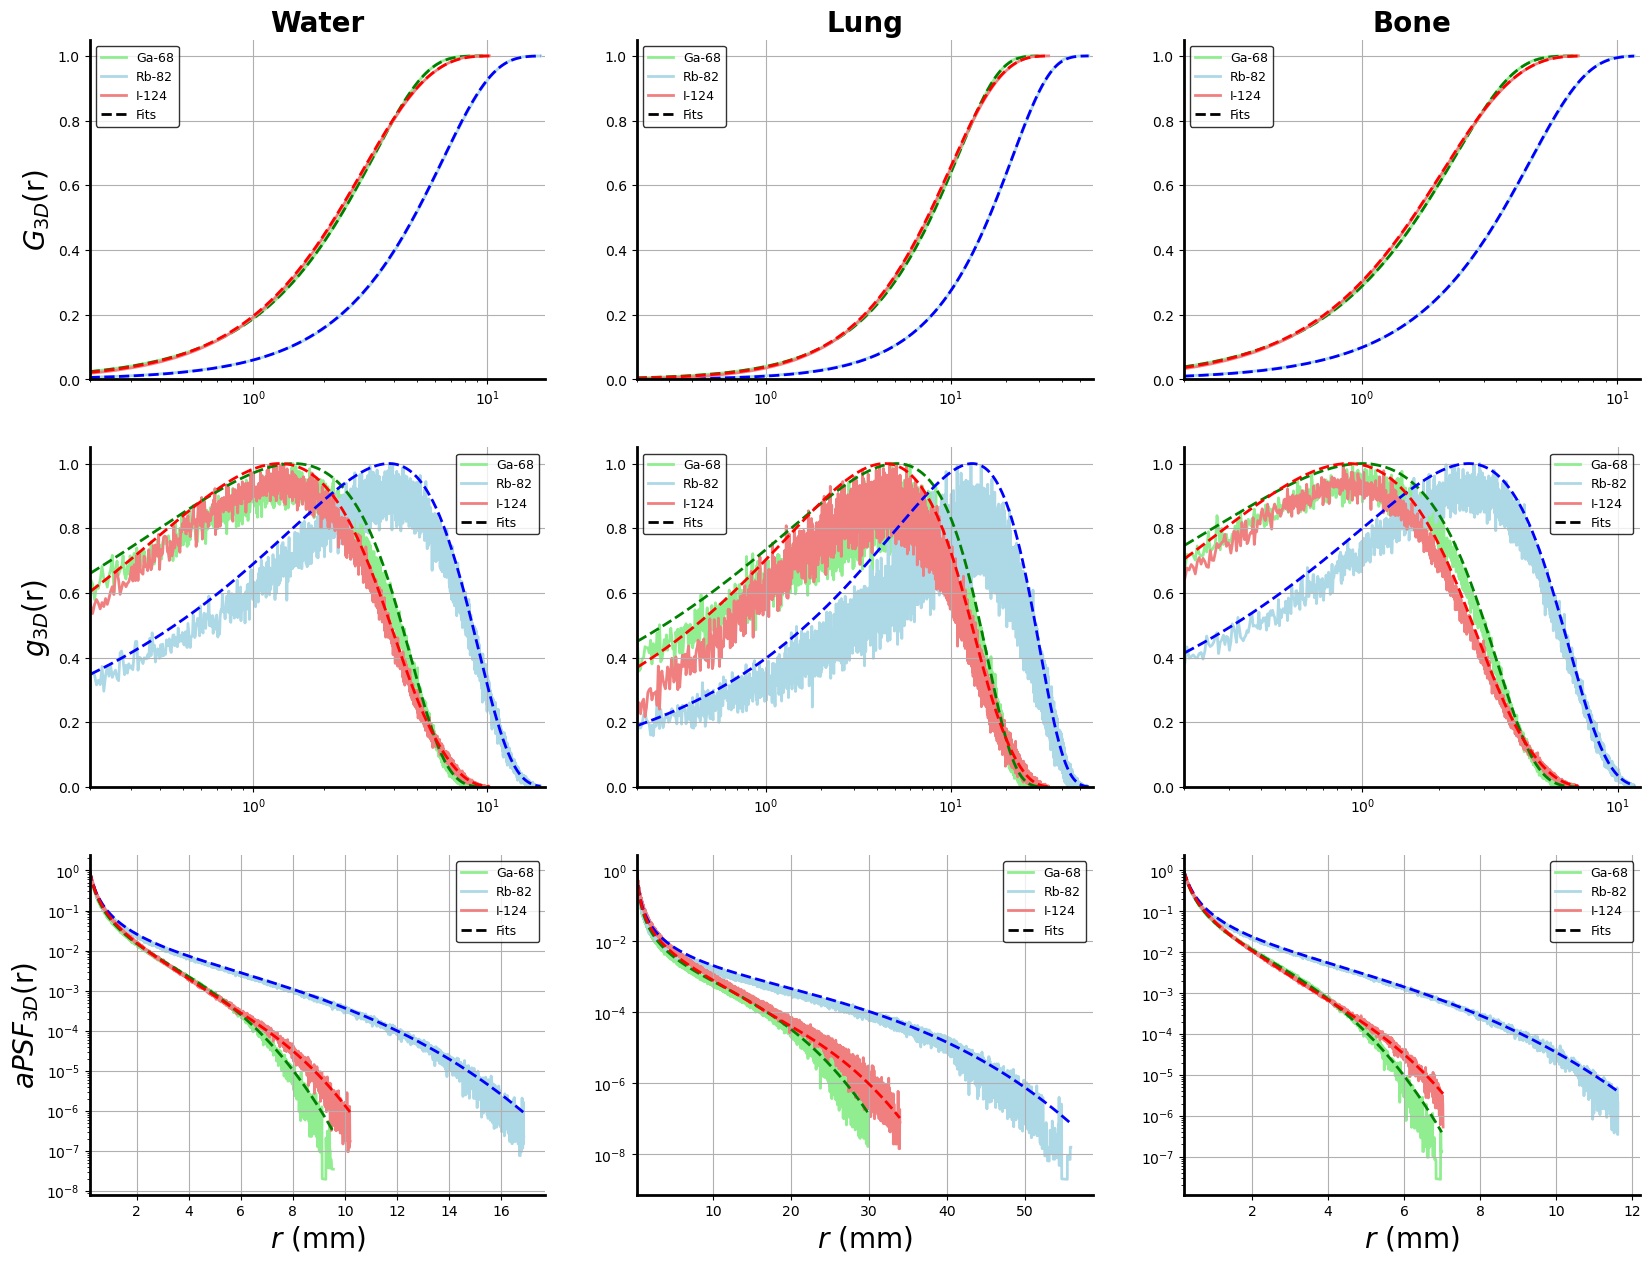

In [23]:
colors1 = ['g', 'b', 'r', 'c', 'm']
colors2 = ['lightgreen', 'lightblue', 'lightcoral', 'paleturquoise', 'violet']
colors = list(zip(colors1, colors2))
cfolders = {
    # "PHITS_xyz":"PHITS",
    # "PenEasy2020_xyz":"SPC",
    "PenEasy2024_xyz":"SPC",
    # "PeneloPET2024_xyz":"2024",
    # "GATE92_xyz":"9",
    # "GATE93_xyz":"9",
    # "GATE7_xyz":"7",
}
clabels = {
    "PHITS_xyz":"PHITS 3.3",
    "PenEasy2020_xyz":"PenEasy 2020",
    "PenEasy2024_xyz":"PenEasy 2024",
    "PeneloPET2024_xyz":"PeneloPET 2024",
    "GATE92_xyz":"GATE 9.2",
    "GATE93_xyz":"GATE 9.3",
    "GATE7_xyz":"GATE 7.0",
}
preffix = "n_is_param"
materials = ["Water", "Lung", "Bone"]       #, "Lung", "Bone"]
isotopes = ["Ga68", "Rb82", "I124"]
iso_colors = dict(zip(isotopes, colors))
bs = 4e-4      #cm
rm = 20e-2      #mm 5e-2

for cfolder, pid in cfolders.items():
    print(f"**********-{cfolder}-**********")
    plt.figure(figsize=(20,15))
    for k,mat in enumerate(materials,1):
        save_file = f"RESULTS/SPC/{mat}/{cfolder}/{pid}-mb_fit-{preffix}.txt"
        for iso in isotopes:
            # Load full isotope sample
            input_file = f"RESULTS/SPC/{mat}/{cfolder}/{iso}.dat" # in cm
            sample_r, sample_G3D = fitPRd.load_nonhisto_G3D(input_file)
            sample_rp, sample_g3D = fitPRd.load_nonhisto_g3D(input_file, tol=bs)
            sample_rp, sample_aPSF3D = fitPRd.load_nonhisto_aPSF3D(input_file, tol=bs)
            sample_r *= 10
            sample_rp *= 10
            trimed_rp = sample_rp[sample_rp > rm]

            # Load each branch fitting parameters
            fit_file = f"RESULTS/MB/{mat}/{cfolder}/{pid}-mb_fit-{preffix}.txt"
            branches = MB[iso]['branches']
            weights = [int(round(w*100)) for _,_,_,w in branches]

            fit_func, argsP, argsC = fitPRd.MBfit_function(*weights)
            fit_func.fitted_params = []

            for i, _ in enumerate(branches):
                isob = f"{iso}-b{i+1}"
                with open(fit_file, "r") as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.startswith(isob):
                            params = [float(x) for x in line.split()[4:]]
                            break
                fit_func.fitted_params += params
            
            # Get final fitting expressions
            final_params = fit_func.get_params(redon=3, with_err=False)
            print(f"{' - '.join([mat, iso]):<20}\t{final_params}")
            # fit_func.show_info(redon=4)
            fit_G3D = fit_func.get_G3D()
            fit_g3D = fit_func.get_g3D()
            fit_aPSF3D = fit_func.get_aPSF3D()

            # Compute quality of fit
            eps = 1e-10
            xdata = sample_r[sample_r > rm]
            ydata = sample_G3D[sample_r > rm]
            denom = np.where(ydata < eps, eps, ydata)

            rmse = np.sqrt(np.sum( (fit_G3D(xdata) - ydata)**2) / len(ydata) ) 
            chi2 = np.sum( (fit_G3D(xdata) - ydata)**2 / denom**2 )
            stderr = chi2 / (len(ydata) - len(final_params))
            print(f"{' ':<20}\t{rmse=:.1e} ({rmse/np.mean(ydata)*100:.2f}%)\t{chi2=:.1e} ({stderr*100:.2f}%)")

            # Plot
            fc, dc = iso_colors[iso]

            plt.subplot(3,3,k)
            plt.plot(sample_r, sample_G3D, '-', label=f'{iso_in_plots(iso)}', color=dc)
            plt.plot(sample_r, fit_G3D(sample_r), '--', label='', color=fc)

            plt.subplot(3,3,k+len(materials))
            plt.plot(trimed_rp, sample_g3D[sample_rp > rm]/sample_g3D[sample_rp > rm].max(), '-', label=f'{iso_in_plots(iso)}', color=dc, zorder=1)
            plt.plot(trimed_rp, (gg:=fit_g3D(trimed_rp))/gg.max(), '--', label='', color=fc, zorder=2)

            plt.subplot(3,3,k+2*len(materials))
            plt.plot(trimed_rp, sample_aPSF3D[sample_rp > rm]/sample_aPSF3D[sample_rp > rm].max(), '-', label=f'{iso_in_plots(iso)}', color=dc, zorder=1)
            plt.plot(trimed_rp, (gg:=fit_aPSF3D(trimed_rp))/gg.max(), '--', label='', color=fc, zorder=2)

        plt.subplot(3,3,k)
        plt.plot([], [], 'k--', label='Fits')
        plt.title(f'{mat}')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$G_{3D}$(r)')
        plt.xlim(rm, None)
        plt.xscale('log')
        aesthetic_plot()
        
        plt.subplot(3,3,k+len(materials))
        plt.plot([], [], 'k--', label='Fits')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$g_{3D}$(r)')
        plt.xlim(rm, None)
        # plt.ylim(7e-1, 1)
        plt.xscale('log')
        aesthetic_plot()

        plt.subplot(3,3,k+2*len(materials))
        plt.plot([], [], 'k--', label='Fits')
        if (k-1) % len(materials) == 0:
            plt.ylabel(r'$aPSF_{3D}$(r)')
        plt.xlabel(r'$r$ (mm)')
        plt.yscale('log')
        plt.xlim(rm, None)
        aesthetic_plot()

    plt.show()